In [21]:
# HOME
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
# use seaborn plotting defaults
import seaborn as sns; sns.set()

# get the code
import sys
sys.path.append('../codeCNV')
from plot import plot_snp
from rollingCNV import apply_rolling_SNP

home = '/Users/mahtin'
home = '/Users/martinscience'
# standard paths
testdata = os.path.join(home,"Dropbox/Icke/Work/somVar/testdata")
static_path = os.path.join(home, "Dropbox/Icke/Work/static")
cluster_path = os.path.join(home, "mount")
tooldata = os.path.join(home, "Dropbox/Icke/Work/somVar/tooldata")

# tool-specific paths
shell_path = "../shell"
# 
cnvdata = os.path.join(tooldata, "myCNVdata")
output_path = os.path.join(cnvdata, "output")

# the path to the input data
cnv_path = os.path.join(cnvdata, "cnv")
cnvPON_path = cnv_path = os.path.join(cnvdata, "chromCov")
cnv_path = os.path.join(cluster_path, "scratch/develop/PONcoverage/cnv")
cnvPON_path = os.path.join(cluster_path, "scratch/develop/PONcoverage/chromCov")

## get the SNP data with FullExonPos

In [22]:
sample = "02_B"
snp_df = pd.read_csv(os.path.join(output_path, f'tmp/{sample}.snpcov.csv'), sep='\t')
snp_df

,Chr,Pos,FullExonPos,ExonPos,log2ratio,log2ratiomean,log2ratiomeanDiff,log2ratiomeanL,log2ratiomeanR,Depth,EBscore,VAF
0,chr1,14930,836,836,1.327717,0.203302,0.0,0.203302,0.203302,38.0,0.799,0.105263
1,chr1,14933,839,839,1.337434,0.203302,0.0,0.203302,0.203302,39.0,1.239,0.076923
2,chr1,15759,930,930,0.691538,0.203302,0.0,0.203302,0.203302,16.0,0.545,0.062500
3,chr1,16949,1410,1410,1.294736,0.203302,0.0,0.203302,0.203302,258.0,0.685,0.286822
4,chr1,17384,1708,1708,0.618725,0.203302,0.0,0.203302,0.203302,292.0,0.402,0.003425
...,...,...,...,...,...,...,...,...,...,...,...,...
736744,chrX,156025116,49470062,1835599,-1.048722,-0.350899,0.0,-0.350899,-0.350899,134.0,1.106,0.522388
736745,chrX,156025122,49470068,1835605,-1.048584,-0.351317,0.0,-0.351317,-0.351317,138.0,0.384,0.007246
736746,chrX,156025182,49470128,1835665,-0.994248,-0.355319,0.0,-0.355319,-0.355319,143.0,0.508,0.006993
736747,chrX,156025194,49470140,1835677,-0.974114,-0.356090,0.0,-0.356090,-0.356090,140.0,0.641,0.007143


In [23]:
snp_df.query('VAF != 1')

,Chr,Pos,FullExonPos,ExonPos,log2ratio,log2ratiomean,log2ratiomeanDiff,log2ratiomeanL,log2ratiomeanR,Depth,EBscore,VAF
0,chr1,14930,836,836,1.327717,0.203302,0.0,0.203302,0.203302,38.0,0.799,0.105263
1,chr1,14933,839,839,1.337434,0.203302,0.0,0.203302,0.203302,39.0,1.239,0.076923
2,chr1,15759,930,930,0.691538,0.203302,0.0,0.203302,0.203302,16.0,0.545,0.062500
3,chr1,16949,1410,1410,1.294736,0.203302,0.0,0.203302,0.203302,258.0,0.685,0.286822
4,chr1,17384,1708,1708,0.618725,0.203302,0.0,0.203302,0.203302,292.0,0.402,0.003425
...,...,...,...,...,...,...,...,...,...,...,...,...
736744,chrX,156025116,49470062,1835599,-1.048722,-0.350899,0.0,-0.350899,-0.350899,134.0,1.106,0.522388
736745,chrX,156025122,49470068,1835605,-1.048584,-0.351317,0.0,-0.351317,-0.351317,138.0,0.384,0.007246
736746,chrX,156025182,49470128,1835665,-0.994248,-0.355319,0.0,-0.355319,-0.355319,143.0,0.508,0.006993
736747,chrX,156025194,49470140,1835677,-0.974114,-0.356090,0.0,-0.356090,-0.356090,140.0,0.641,0.007143


In [24]:
snp_df.query('VAF > 0.95')

,Chr,Pos,FullExonPos,ExonPos,log2ratio,log2ratiomean,log2ratiomeanDiff,log2ratiomeanL,log2ratiomeanR,Depth,EBscore,VAF
9,chr1,69270,2994,2994,1.597339,0.203302,0.000000,0.203302,0.203302,67.0,0.542,1.000000
10,chr1,69511,3192,3192,1.086617,0.203302,0.000000,0.203302,0.203302,567.0,0.020,1.000000
42,chr1,941119,11554,11554,0.286328,0.198810,0.000000,0.198810,0.198810,124.0,0.763,1.000000
57,chr1,942451,12046,12046,0.855758,0.213817,0.000000,0.213817,0.213817,75.0,0.003,1.000000
108,chr1,944858,13679,13685,-0.494051,0.243251,0.000000,0.243251,0.243251,237.0,0.990,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
736300,chrX,154532293,49422655,1788192,0.532252,0.029050,0.015371,0.084687,-0.073330,336.0,2.662,0.997024
736304,chrX,154532439,49422801,1788338,0.148397,0.027871,0.017012,0.086411,-0.075682,560.0,3.328,1.000000
736406,chrX,154766321,49436060,1801597,-0.401138,-0.113587,0.130649,0.048643,-0.221197,360.0,0.009,1.000000
736728,chrX,156022319,49468956,1834493,0.344496,-0.343517,0.000000,-0.343517,-0.343517,14.0,0.096,1.000000


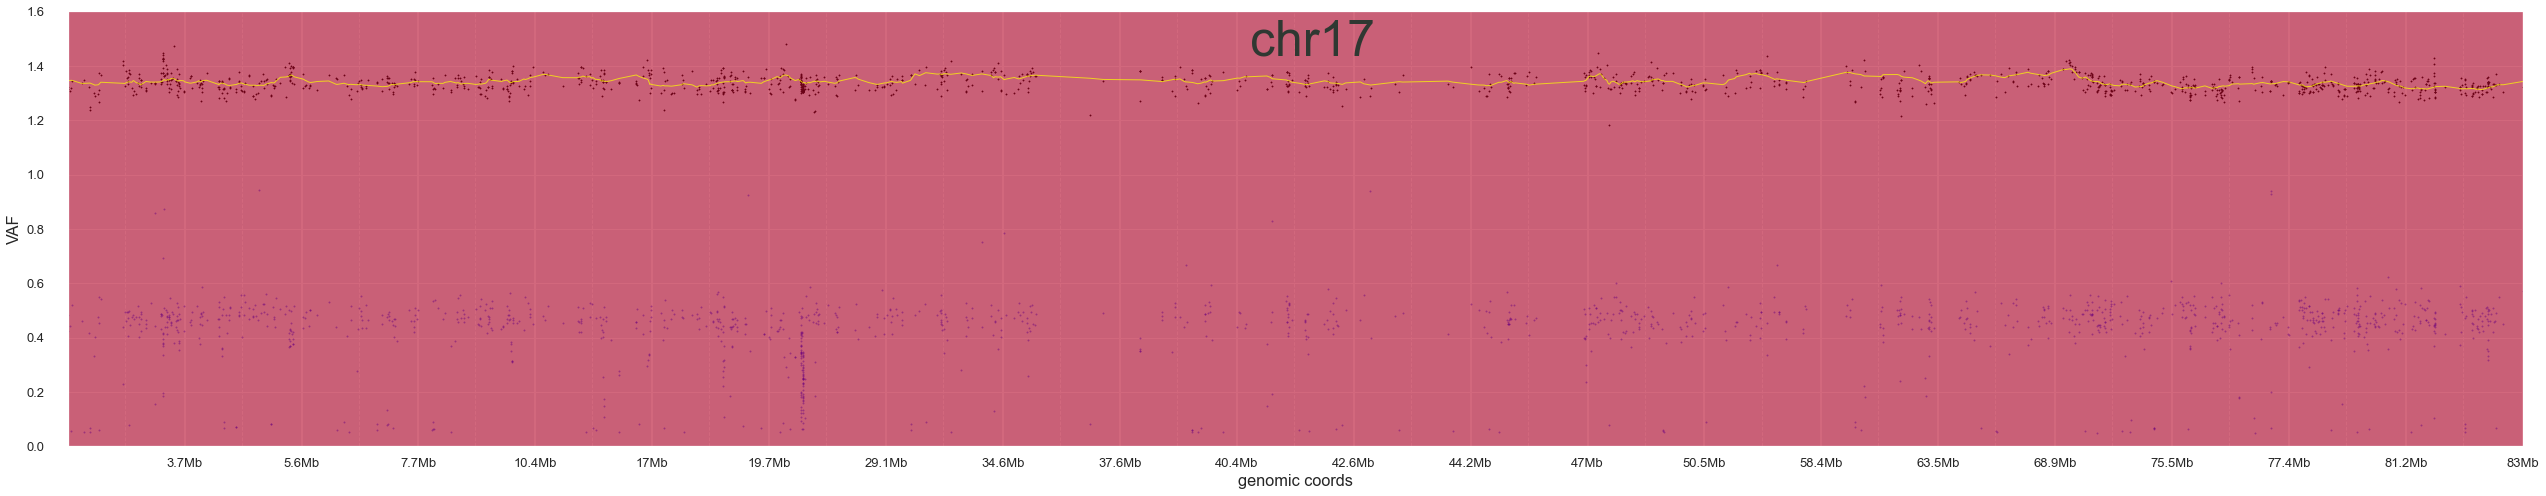

In [25]:

log2 = dict(
        title='log2ratio',
        plot_type='scatter',   # ['line', 'scatter']
        data='log2ratio',
        plot_args=dict(
            linewidth=0.3,
            color='black',
            s=2,
            alpha=1
        )
    )

log2mean = dict(
        title='rollinglog2ratio',
        plot_type='line',   # ['line', 'scatter']
        data='log2ratiomean',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )
vaf = dict(
        title='VAF',
        plot_type='scatter',   # ['line', 'scatter']
        data='VAF',
        plot_args=dict(
            linewidth=0.5,
            color='blue',
            s=2,
            alpha=.4
        ))

fig_params = dict(
    figsize=(44,8),
    colormap='coolwarm_r',
    color_chroms=True,
    ylim=(0,1),
    cov_offset=.1,  # how much log2ratio=0 is shifted above SNP-data
    cov_height=.5,
    label_size=13
)

chroms = ['chr5', 'chr7','chr8', 'chr11', 'chr17']
r1 = 'chr17:3Mb-9Mb'

sample = "05_B"
snp_df = pd.read_csv(os.path.join(output_path, f'CNV/{sample}.roll.snp'), sep='\t').dropna()


_ = plot_snp(snp_df, snp_plots=[vaf], cov_plots=[log2, log2mean], chroms='all', region='chr17', **fig_params)

In [ ]:
plot_2d(snp_df)

### run the code

In [ ]:
config = {
    'debug': False, # also export the left and right rolling window values (L/R)
    'diff_exp': 4, # the exponent for the diff function --> higher values make steeper peaks
    'coverage': {
        'filter': dict(
            min_cov = 30,
            min_PON_cov = 50,
            max_PON_std = 100,
        ),
        'normalize':False,
        'center': True,
        'expand':0.2, # after interpolation of rolling data from filtered df into full df, interpolate missing data within this fraction of window size, set 0 if no interpolation is wanted
        'data': {
            'log2ratio': {
                'mean':100
            }
        }
    },
    'heteroSNP': {
        'filter': dict(
            VAF=(0.05,0.95),
            minDepth=30,
            minEB=0.5
        ),
        'normalize': True,
        'center':False,
        'expand': 0.5,
        'data': {
            'absVAF': {
                'mean': 20
            },
            'VAF': {
                'std': 20
            },
            'deltaVAF': {
                'var': 20,
                'std': 20
            }
        }
    }
}

In [ ]:
snp2_df = apply_rolling_SNP(snp_df, config)
snp2_df.to_csv(os.path.join(output_path, f'rollingCNV/{sample}.snp.csv'), sep='\t', index=False)

In [ ]:
snp_df

### visualize the data

In [ ]:
log2 = dict(
        title='log2ratio',
        plot_type='scatter',   # ['line', 'scatter']
        data='log2ratio',
        plot_args=dict(
            linewidth=0.3,
            color='black',
            s=0.2,
            alpha=.7
        )
    )

log2mean = dict(
        title='rollinglog2ratio',
        plot_type='line',   # ['line', 'scatter']
        data='log2ratiomean',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )

vaf = dict(
        title='VAF',
        plot_type='scatter',  # ['line', 'scatter']
        data='VAF',
        plot_args=dict(
            s=.2,
            color='black',
            alpha=.7
        )
    )

fig_params = dict(
    figsize=(24,8),
    colormap='coolwarm_r',
    color_chroms=True,
    ylim=(0,1),
    cov_offset=.1,  # how much log2ratio=0 is shifted above SNP-data
    cov_height=.5,
    label_size=13
)
chroms = ['chr5', 'chr7','chr8', 'chr11', 'chr17']
r1 = 'chr17:3Mb-9Mb'

fig, ax, df, chrom_df = plot_snp(snp_df, snp_plots=[vaf], cov_plots=[log2, log2mean], chroms='all', region='', **fig_params)

## heteroSNP rolling window
+ #### first, the center cluster has to be fitted via clustering to identify the centers for mean correction

In [ ]:
config = {
    'debug': True, # also export the left and right rolling window values (L/R)
    'coverage': {
        'filter': dict(
            min_cov = 30,
            min_PON_cov = 50,
            max_PON_std = 100,
        ),
        'normalize':False,
        'center': True,
        'expand':0.2, # after interpolation of rolling data from filtered df into full df, interpolate missing data within this fraction of window size, set 0 if no interpolation is wanted
        'data': {
            'log2ratio': {
                'mean':100
            }
        }
    },
    'heteroSNP': {
        'filter': dict(
            VAF=(0.05,0.95),
            minDepth=30,
            minEB=0.5
        ),
        'normalize': True,
        'center':False,
        'expand': 0.5,
        'data': {
            'absVAF': {
                'mean': 20
            },
            'VAF': {
                'std': 20
            },
            'deltaVAF': {
                'var': 20,
                'std': 20
            }
        }
    }
}

from cluster import center_data

snp_df = center_data(snp_df, config)

### extract important features from SNPdata
+ absVAF is distance of heteroSNP to 0.5
+ deltaVAF is difference between adjacent SNPs

In [ ]:
def expand_SNPdata(snp_df, config):
    '''
    retrieve a few data columns locally to use rolling windows on
    this needs to be done chromosome-wise in order to avoid gap effects
    VAF limits are also applied here
    '''

    # split the params dict for easier access
    params = config['heteroSNP']
    filter_params = params['filter']
    data_params = params['data']
    # reduce the snp_df using config limits
    VAFmin, VAFmax = filter_params['VAF']
    snp_df = snp_df.query('@VAFmin < VAF < @VAFmax')
    
    # get the new features from VAFs
    snp_df.loc[:,'absVAF'] = np.abs(snp_df['VAF'] - 0.5) * 2
    # get the local VAF difference chrom based
    dfs = []
    for chrom in snp_df['Chr'].unique():
        chrom_df = snp_df.query('Chr == @chrom')
        chrom_df.loc[:, 'deltaVAF'] = np.abs(chrom_df['VAF'] - chrom_df.shift(1)['VAF']).fillna(0)
        dfs.append(chrom_df)
    snp_df = pd.concat(dfs).sort_values('FullExonPos')
    return snp_df.reset_index(drop=True)

In [ ]:
snp2_df = expand_SNPdata(snp_df, config)
snp2_df

In [ ]:
fig_params = dict(
    figsize=(24,8),
    colormap='coolwarm_r',
    color_chroms=True,
    ylim=(-0.02,1.05),
    cov_offset=.1,  # how much log2ratio=0 is shifted above SNP-data
    cov_height=.5,
    label_size=13
)


absvaf = dict(
        title='absVAF',
        plot_type='scatter',   # ['line', 'scatter']
        data='absVAF',
        plot_args=dict(
            linewidth=0.5,
            color='blue',
            s=1,
            alpha=1
        ))
deltavaf = dict(
        title='deltaVAF',
        plot_type='scatter',   # ['line', 'scatter']
        data='deltaVAF',
        plot_args=dict(
            linewidth=0.5,
            color='green',
            s=5,
            alpha=1
        ))

chroms = ['chr5', 'chr7','chr8', 'chr11', 'chr17']
r1 = 'chr17:3Mb-9Mb'

fig, ax, df, chrom_df = plot_snp(snp2_df, snp_plots=[deltavaf, absvaf], cov_plots=[log2, log2mean], chroms=chroms, region='', **fig_params)

## Rolling SNPdata

In [ ]:
from rollingCNV import one_col_rolling

def rolling_SNP(snp_df, config):
    '''
    cycle through the chroms and perform rolling window computations of snp data set in config
    '''
    
    # split the params dict for easier access
    params = config['heteroSNP']
    filter_params = params['filter']
    data_params = params['data']
    # reduce the snp_df using config limits
    VAFmin, VAFmax = filter_params['VAF'] 
    minDepth = filter_params['minDepth']
    minEBscore = filter_params['minEB']
    
    # cycle through chroms for 
    chrom_dfs = []
    for chrom in snp_df['Chr'].unique():
        # restrict to chrom
        chrom_df = snp_df.query('Chr == @chrom').sort_values('FullExonPos')        
        # filter df
        filter_df = snp_df.query('Depth >= @minDepth and EBscore > @minEBscore') #.query('@VAFmin < VAF < @VAFmax and 
        for data_col in data_params.keys():
            for agg in data_params[data_col].keys():
                window_size = data_params[data_col][agg]
                expand_limit = int(params['expand'] * window_size)
                # print(f"Computing rolling window for {agg} of {data_col} with window size {window_size} on {chrom}")
                chrom_df = one_col_rolling(chrom_df, filter_df, data_col, agg, window_size=window_size, expand_limit=expand_limit, normalize=params['normalize'], debug=config['debug'])
        chrom_dfs.append(chrom_df)
    df = pd.concat(chrom_dfs).sort_values('FullExonPos')
    return df

### test rolling windows

In [ ]:
snp_config = {
    'heteroSNP': {
        'filter': dict(
            VAF=(0.05,0.95),
            minDepth=10,
            minEB=0.5
        ),
        'normalize': True,
        'center':False,
        'expand': .75,
        'data': {
            'absVAF': {
                'mean': 20
            }
        }
    }   
}

config.update(snp_config)
snp3_df = rolling_SNP(snp2_df, config)
snp3_df[:10]

## optimizing rolling windows

### VAF
+ std  (20)
+ var

In [ ]:
vaf = dict(
        title='VAF',
        plot_type='scatter',   # ['line', 'scatter']
        data='VAF',
        plot_args=dict(
            linewidth=0.5,
            color='blue',
            s=5,
            alpha=1
        ))
vafvar = dict(
        title='VAFstd',
        plot_type='line',   # ['line', 'scatter']
        data='VAFvar',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )

vafvardiff = dict(
        title='VAFstdDiff',
        plot_type='line',   # ['line', 'scatter']
        data='VAFvarDiff',
        plot_args=dict(
            linewidth=1,
            color='blue',
            alpha=.7
        )
    )

vafstd = dict(
        title='VAFstd',
        plot_type='line',   # ['line', 'scatter']
        data='VAFstd',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )

vafstddiff = dict(
        title='VAFstdDiff',
        plot_type='line',   # ['line', 'scatter']
        data='VAFstdDiff',
        plot_args=dict(
            linewidth=1,
            color='blue',
            alpha=.7
        )
    )

snp_config = {
    'heteroSNP': {
        'filter': dict(
            VAF=(0.05,0.95),
            minDepth=10,
            minEB=0.5
        ),
        'normalize': True,
        'center':False,
        'expand': .75,
        'data': {
            'VAF': {
                'var': 20,
                'std': 20
            }
        }
    }   
}

config.update(snp_config)
snp3_df = rolling_SNP(snp2_df, config)

chroms = ['chr5', 'chr7','chr8', 'chr11', 'chr17']
r1 = 'chr17:3Mb-9Mb'

std_plots = [vaf,vafstd, vafstddiff]
var_plots = [vaf,vafvar, vafvardiff]
fig, ax, df, chrom_df = plot_snp(snp3_df, snp_plots=std_plots, chroms=chroms, region='', **fig_params)

### absVAF
+ mean (20)
+ std

In [ ]:
absvafstd = dict(
        title='absVAFstd',
        plot_type='line',   # ['line', 'scatter']
        data='absVAFstd',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )

absvafstddiff = dict(
        title='absVAFstddiff',
        plot_type='line',   # ['line', 'scatter']
        data='absVAFstdDiff',
        plot_args=dict(
            linewidth=1,
            color='blue',
            alpha=.7
        )
    )

absvaf = dict(
        title='absVAF',
        plot_type='scatter',   # ['line', 'scatter']
        data='absVAF',
        plot_args=dict(
            linewidth=0.5,
            color='blue',
            s=5,
            alpha=1
        ))
absvafmean = dict(
        title='absVAFmean',
        plot_type='line',   # ['line', 'scatter']
        data='absVAFmean',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )

absvafmeandiff = dict(
        title='absVAFdiff',
        plot_type='line',   # ['line', 'scatter']
        data='absVAFmeanDiff',
        plot_args=dict(
            linewidth=1,
            color='blue',
            alpha=.7
        )
    )

snp_config = {
    'heteroSNP': {
        'filter': dict(
            VAF=(0.05,0.95),
            minDepth=10,
            minEB=0.5
        ),
        'normalize': True,
        'center':False,
        'expand': .75,
        'data': {
            'absVAF': {
                'mean': 20,
                'std': 20
            }
        }
    }   
}

config.update(snp_config)
snp3_df = rolling_SNP(snp2_df, config)

chroms = ['chr5', 'chr7','chr8', 'chr11', 'chr17']
r1 = 'chr17:3Mb-9Mb'
mean_plots = [absvaf,absvafmean, absvafmeandiff]
std_plots = [absvaf,absvafstd, absvafstddiff]
fig, ax, df, chrom_df = plot_snp(snp3_df, snp_plots=mean_plots, chroms=chroms, region=r1, **fig_params)

### deltaVAF
+ mean
+ var (20)
+ std 

In [ ]:
deltavafstd = dict(
        title='deltaVAFstd',
        plot_type='line',   # ['line', 'scatter']
        data='deltaVAFstd',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )

deltavafstddiff = dict(
        title='deltaVAFstddiff',
        plot_type='line',   # ['line', 'scatter']
        data='deltaVAFstdDiff',
        plot_args=dict(
            linewidth=1,
            color='blue',
            alpha=.7
        )
    )

deltavaf = dict(
        title='deltaVAF',
        plot_type='scatter',   # ['line', 'scatter']
        data='deltaVAF',
        plot_args=dict(
            linewidth=0.5,
            color='blue',
            s=5,
            alpha=1
        ))
deltavafmean = dict(
        title='deltaVAFmean',
        plot_type='line',   # ['line', 'scatter']
        data='deltaVAFmean',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )

deltavafmeandiff = dict(
        title='deltaVAFmeandiff',
        plot_type='line',   # ['line', 'scatter']
        data='deltaVAFmeanDiff',
        plot_args=dict(
            linewidth=1,
            color='blue',
            alpha=.7
        )
    )

deltavafvar = dict(
        title='deltaVAFvar',
        plot_type='line',   # ['line', 'scatter']
        data='deltaVAFvar',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )

deltavafvardiff = dict(
        title='deltaVAFvardiff',
        plot_type='line',   # ['line', 'scatter']
        data='deltaVAFvarDiff',
        plot_args=dict(
            linewidth=1,
            color='blue',
            alpha=.7
        )
    )

snp_config = {
    'heteroSNP': {
        'filter': dict(
            VAF=(0.05,0.95),
            minDepth=10,
            minEB=0.5
        ),
        'normalize': True,
        'center':False,
        'expand': .75,
        'data': {
            'deltaVAF': {
                'var': 20,
                'std': 20
            }
        }
    }   
}

config.update(snp_config)
snp3_df = rolling_SNP(snp2_df, config)

mean_plots = [deltavaf,deltavafmean, deltavafmeandiff]
std_plots = [deltavaf,deltavafstd, deltavafstddiff]
var_plots = [deltavaf,deltavafvar, deltavafvardiff]
fig, ax, df, chrom_df = plot_snp(snp3_df, snp_plots=var_plots, chroms=chroms, region='', **fig_params)

## bring all together
+ center snp_df
+ get extra data
+ do the rolling

In [ ]:
def apply_rolling_SNP(snp_df, config):
    # center the data
    snp_df = center_data(snp_df, config)
    # get extra data
    snp_df = expand_SNPdata(snp_df, config)
    # do the rolling
    snp_df = rolling_SNP(snp2_df, config)
    return snp_df

In [ ]:
config = {
    'debug': False, # also export the left and right rolling window values (L/R)
    'coverage': {
        'filter': dict(
            min_cov = 30,
            min_PON_cov = 50,
            max_PON_std = 100,
        ),
        'normalize':False,
        'center': True,
        'expand':0.2, # after interpolation of rolling data from filtered df into full df, interpolate missing data within this fraction of window size, set 0 if no interpolation is wanted
        'data': {
            'log2ratio': {
                'mean':100
            }
        }
    },
    'heteroSNP': {
        'filter': dict(
            VAF=(0.05,0.95),
            minDepth=30,
            minEB=0.5
        ),
        'normalize': True,
        'center':False,
        'expand': 0.5,
        'data': {
            'absVAF': {
                'mean': 20
            },
            'VAF': {
                'std': 20
            },
            'deltaVAF': {
                'var': 20,
                'std': 20
            }
        }
    }
}

rSNP_df = apply_rolling_SNP(snp_df, config)

In [ ]:
rSNP_df